# jammer
## 15 - Explore the new IGRINS data
### Part I. New data!

In [1]:
import pandas as pd

In [2]:
#! head -n 30 ../data/IGRINS/2M0136+0933_20161101_H_0030_merged.txt

In [3]:
dat = pd.read_csv('../data/IGRINS/2M0136+0933_20161101_H_0030_merged.txt', names=['wl', 'fl', 'sigma', 'msk'],
                  comment='#', delim_whitespace=True)

>The files have four columns each. The first is wavelength in microns. The second is flux, units are ergss-1cm-2A-1. The third and fourth columns I would ignore. The third one should be uncertainty but we aren't really sure we can trust those with the IGRINS data, and the fourth is a flag array that the SpeX data has but the IGRINS data doesn't, so its all zeroes. 

In [4]:
dat.head()

,wl,fl,sigma,msk
0,1.44088,-2086320.0,2223908.8,0.0
1,1.44090,-2811440.0,1738085.4,0.0
2,1.44091,26376000.0,8016290.5,0.0
3,1.44092,2313210.0,2858560.5,0.0
4,1.44093,-707306.0,1232425.1,0.0


## An example Marley model

In [5]:
mar = pd.read_csv('../../Starfish/libraries/raw/marley13/sp_t1300g1780nc_m0.0', 
                  names=['wavelength', 'flux'],
                  skiprows=3, 
                  delim_whitespace=True)

In [6]:
import astropy.units as u
import astropy.constants as C
c_val = C.c.to(u.cm/u.s).value
c_val

29979245800.0

In [7]:
x = mar.wavelength.values*u.micron
x_Hz = x.to(u.Hz, equivalencies=u.spectral())
x_Ang = x.to(u.Angstrom)


y0 = mar.flux.values*u.erg/u.cm**2/u.s/u.Hz
y = y0.to(u.erg/u.cm**2/u.s/u.Angstrom, 
          equivalencies=u.spectral_density(mar.wavelength.values*u.micron))

In [8]:
yl1, yl2 = np.nanpercentile(dat.fl, [10, 90])

(1.4, 1.85)

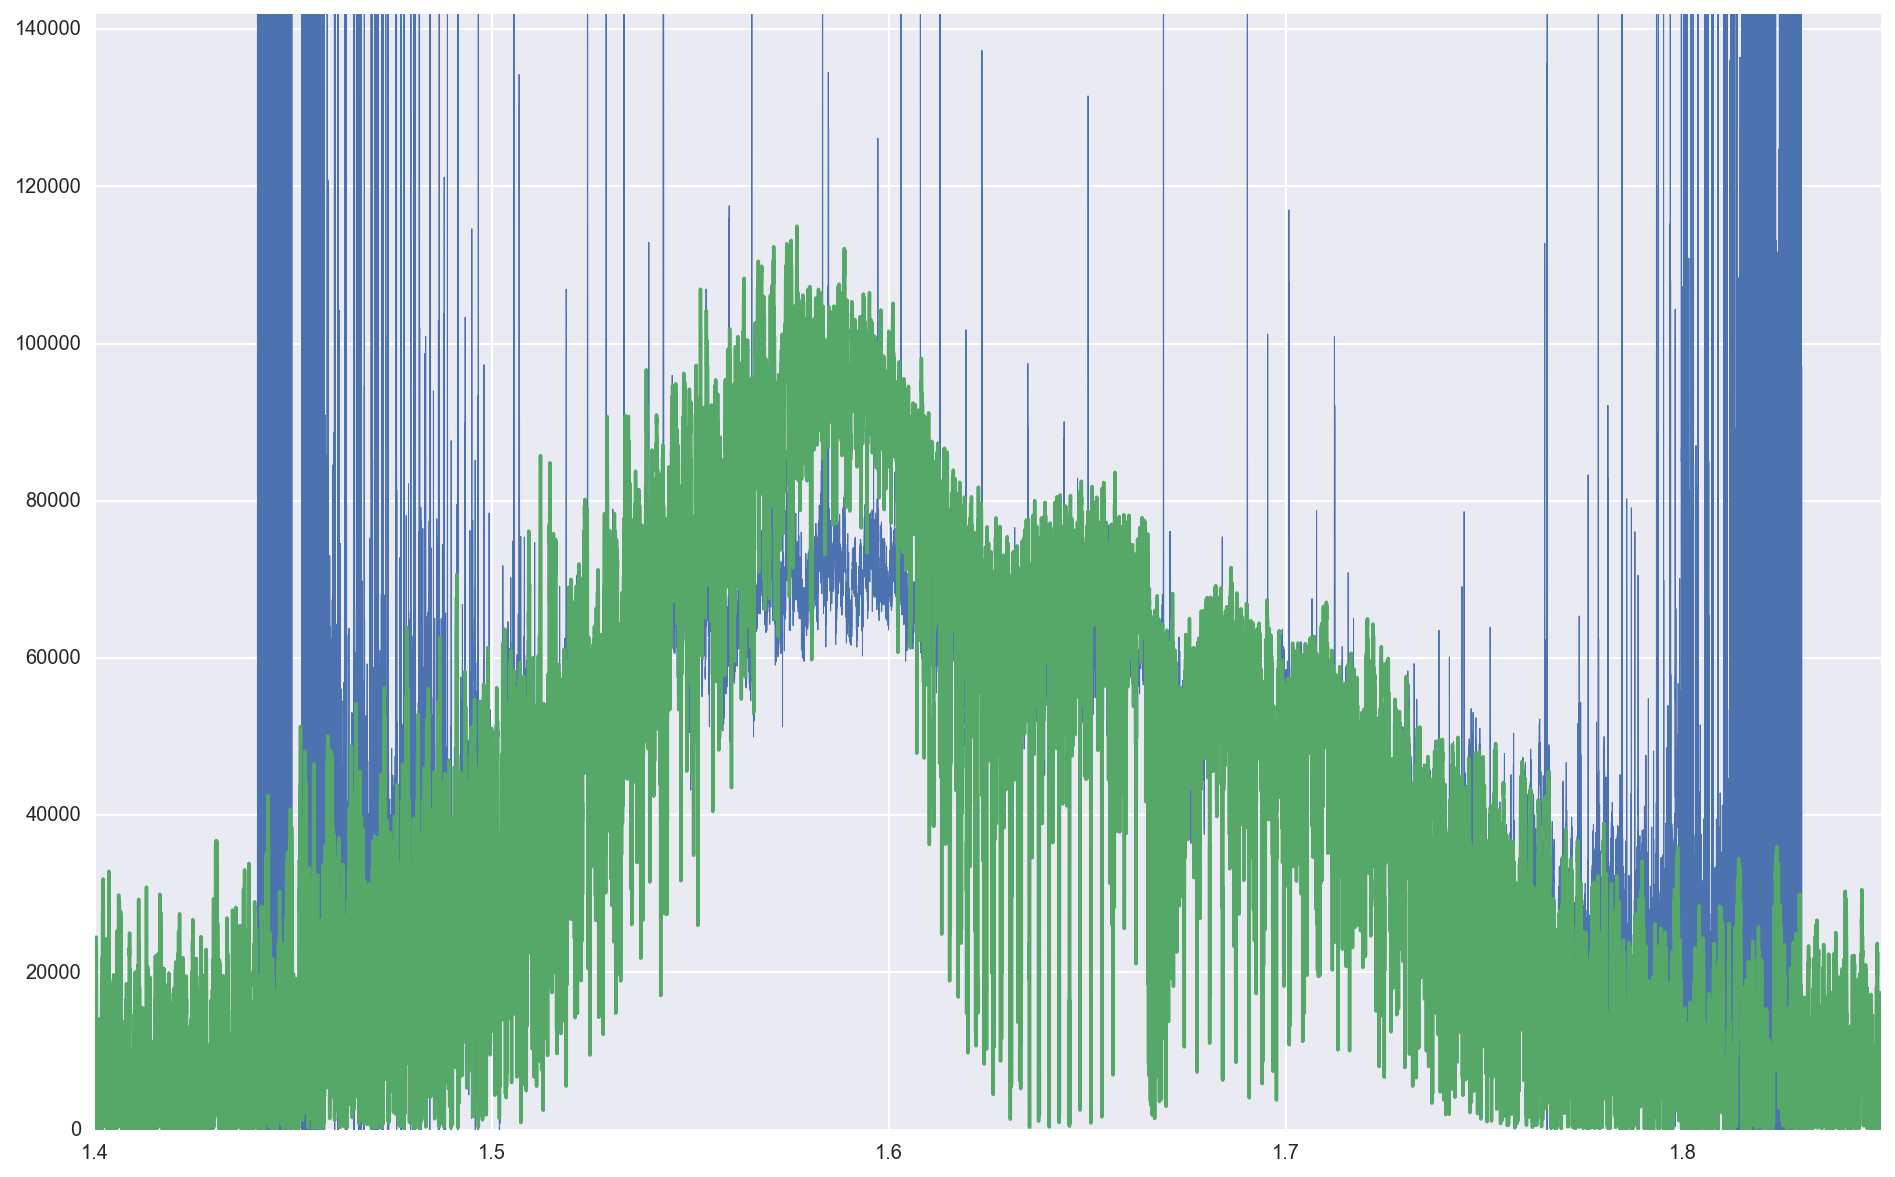

In [9]:
plt.figure(figsize=(16, 10))
plt.plot(dat.wl, dat.fl, lw=0.5)
plt.plot(x, y*6)
plt.ylim(0, 2.0*yl2)
plt.xlim(1.4, 1.85)

omg awesome, flux calibrated high resolution spectra, wtf!!

What's the $S/N$?

In [10]:
dat['sigma']=dat.sigma.astype(np.float)

In [11]:
len(dat)

36302

(-50, 100)

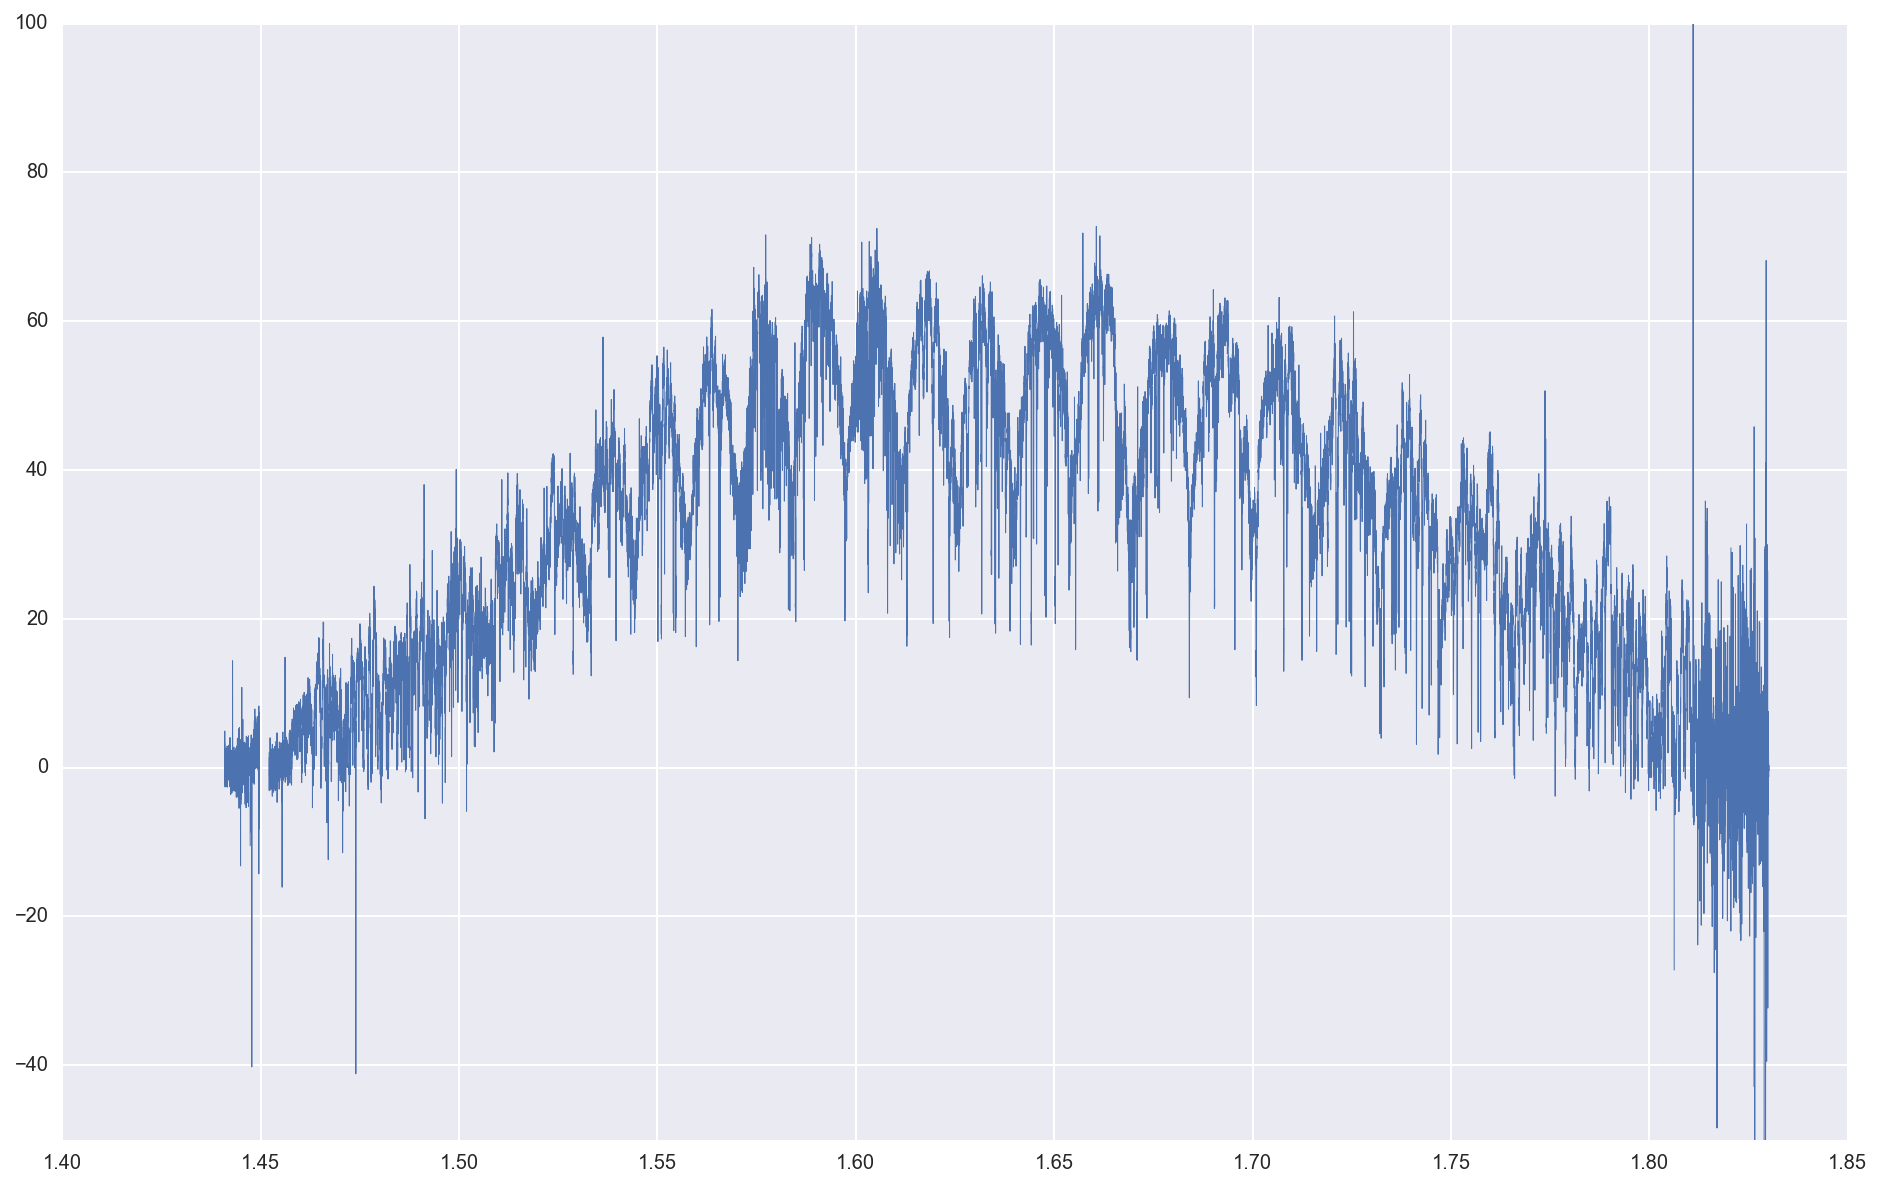

In [12]:
plt.figure(figsize=(16, 10))
plt.plot(dat.wl, dat.fl/dat.sigma, lw=0.5)
plt.ylim(-50, 100)

Wow, the $S/N$ looks like it's accurate!  Or at least sensible.  You can see the blaze shape :)

In [13]:
# we did m118 already
x1, x2 = 1.533, 1.544 # m117
x1, x2 = 1.5445, 1.557 # m116
x1, x2 = 1.559, 1.570 # m115
x1, x2 = 1.572, 1.583 # m114
# we did m113 already
x1, x2 = 1.598, 1.611 # m112
x1, x2 = 1.612, 1.625 # m111
x1, x2 = 1.626, 1.639 # m110
x1, x2 = 1.641, 1.653 # m109
# we did m108 already

(1.621, 1.673)

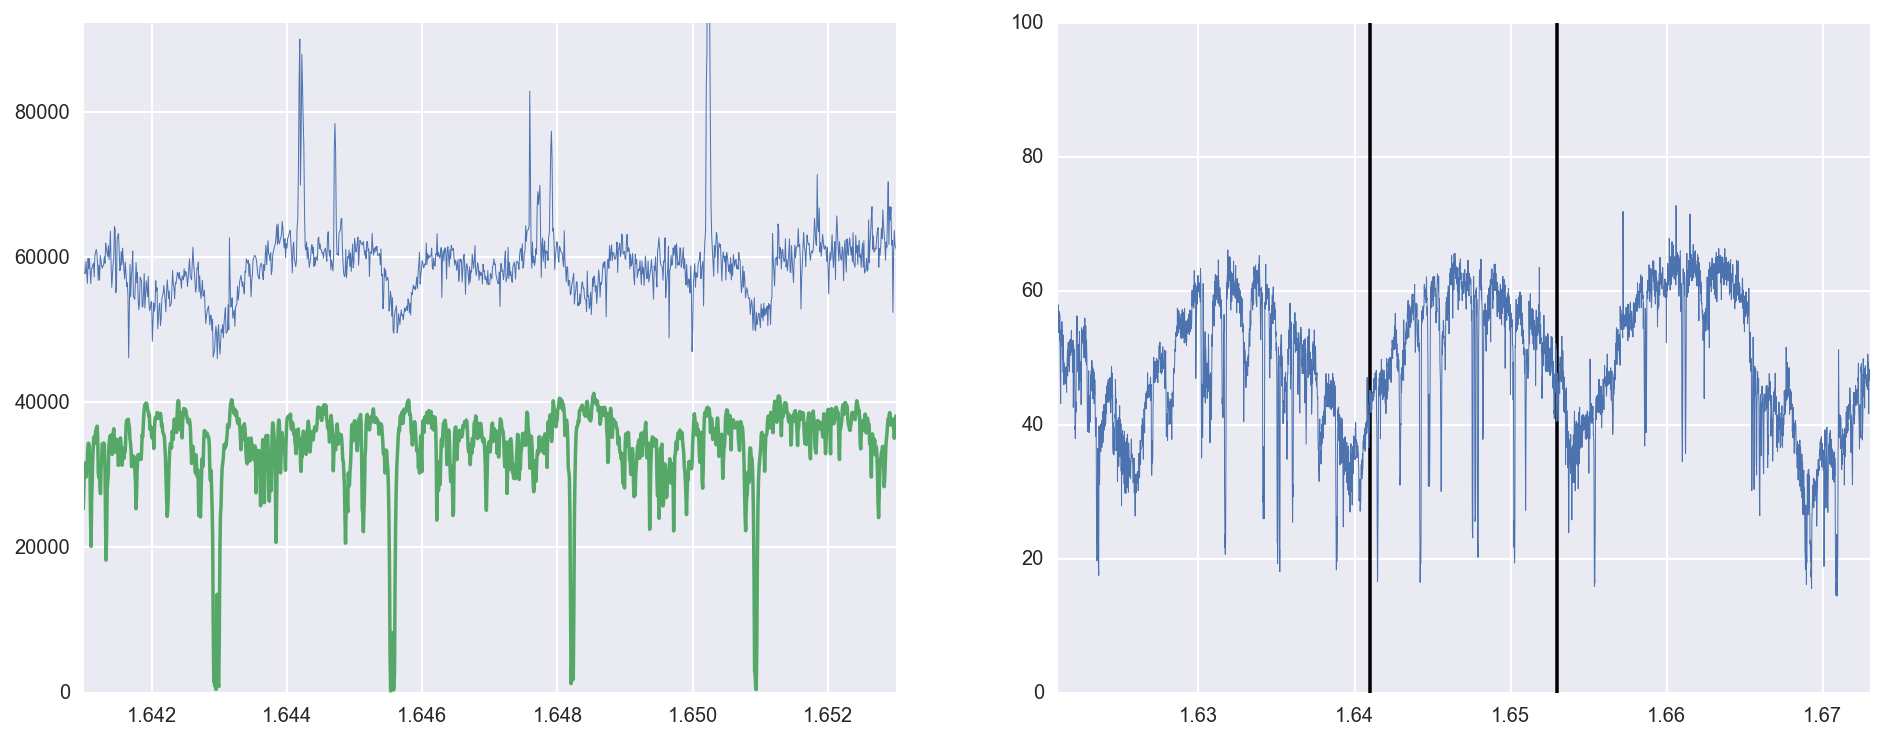

In [14]:
x1, x2 = 1.641, 1.653 # m109
plt.figure(figsize=(16, 6))
plt.subplot(121)
plt.plot(dat.wl, dat.fl, lw=0.5)
plt.plot(x, y*3)
plt.ylim(0, 1.3*yl2)
plt.xlim(x1, x2)
plt.subplot(122)
plt.plot(dat.wl, dat.fl/dat.sigma, lw=0.5)
plt.vlines(x1, 0, 100)
plt.vlines(x2, 0, 100)
plt.ylim(0, 100)
plt.xlim(x1-0.02, x2+0.02)

## Save to HDF5 for Starfish

Clean the data and put into a form for Starfish ingestion

In [15]:
import h5py

In [31]:
# we did m118 already
x1, x2 = 1.533, 1.544 # m117
x1, x2 = 1.5445, 1.557 # m116
x1, x2 = 1.559, 1.570 # m115
x1, x2 = 1.572, 1.583 # m114
# we did m113 already
x1, x2 = 1.598, 1.611 # m112
x1, x2 = 1.612, 1.625 # m111
x1, x2 = 1.626, 1.639 # m110
x1, x2 = 1.641, 1.653 # m109
# we did m108 already

### x1, x2 = 1.641, 1.653 # m109

In [88]:
x1, x2 = 1.641, 1.653 # m109
gi = (dat.wl> x1) & (dat.wl < x2)
wlgrid = dat.wl[gi].values
Flux = dat.fl[gi].values
Flux_err = np.abs(dat.sigma[gi].values)

Let's manually clean the bad pixels.

(0, 100000)

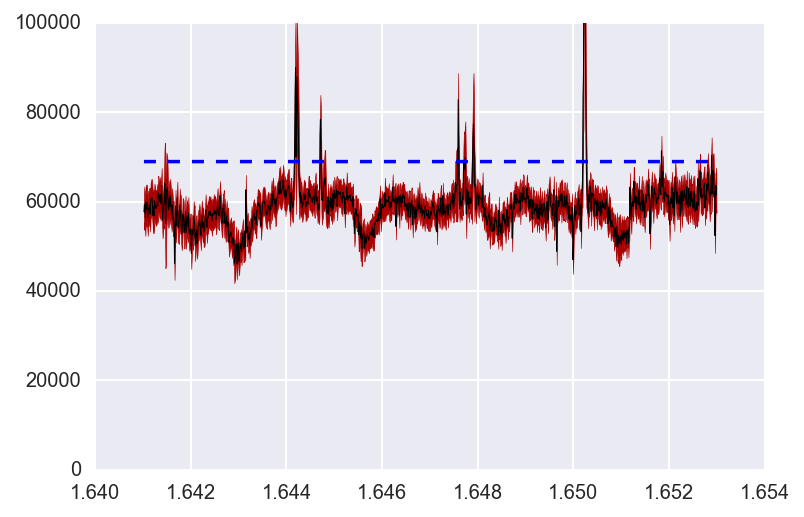

In [89]:
plt.plot(wlgrid, Flux, 'k-', lw=0.5)
plt.fill_between(wlgrid, Flux-3.0*Flux_err, Flux+3.0*Flux_err, color='#AA0000')
plt.plot(wlgrid, wlgrid*0.0+69000, 'b--')
plt.ylim(0,100000)

In [90]:
bi = (Flux > 69000) | (Flux_err == 0)
Flux_err_alt = Flux_err[~bi]
Flux = Flux[~bi]
wlgrid = wlgrid[~bi]

(0, 100000)

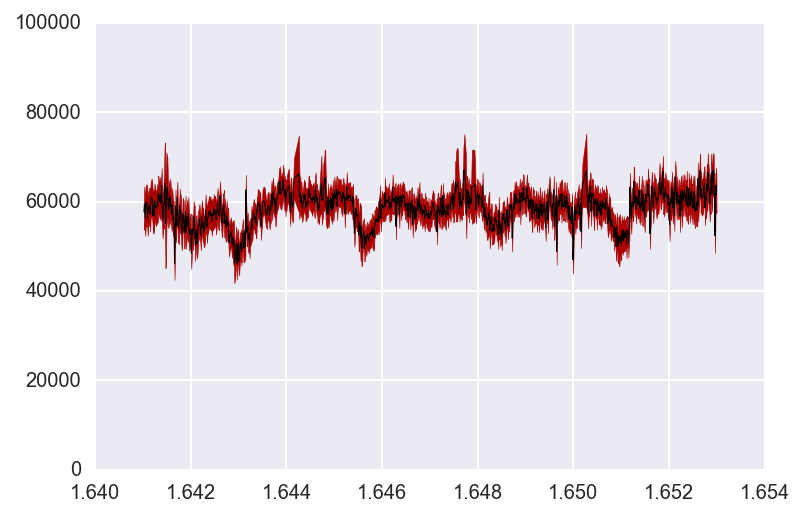

In [91]:
plt.plot(wlgrid, Flux, 'k-', lw=0.5)
plt.fill_between(wlgrid, Flux-3.0*Flux_err_alt, Flux+3.0*Flux_err_alt, color='#AA0000')
plt.ylim(0,100000)

Much better.

In [92]:
out_name = '../data/IGRINS/reduced/2M0136+0933_m109.hdf5'
fls_out = Flux
sig_out = Flux_err_alt
wls_out = wlgrid*10000.0
msk_out = np.ones(len(wls_out), dtype=int)
f_new = h5py.File(out_name, 'w')
f_new.create_dataset('fls', data=fls_out)
f_new.create_dataset('wls', data=wls_out)
f_new.create_dataset('sigmas', data=sig_out)
f_new.create_dataset('masks', data=msk_out)
print("{:.0f}  -  {:.0f}   {}".format(wls_out[0], wls_out[-1], out_name))
f_new.close()

16410  -  16530   ../data/IGRINS/reduced/2M0136+0933_m109.hdf5


### x1, x2 = 1.626, 1.639 # m110

In [22]:
x1, x2 = 1.626, 1.639 # m110
gi = (dat.wl> x1) & (dat.wl < x2)
wlgrid = dat.wl[gi].values
Flux = dat.fl[gi].values
Flux_err = np.abs(dat.sigma[gi].values)

Let's manually clean the bad pixels.

(0, 100000)

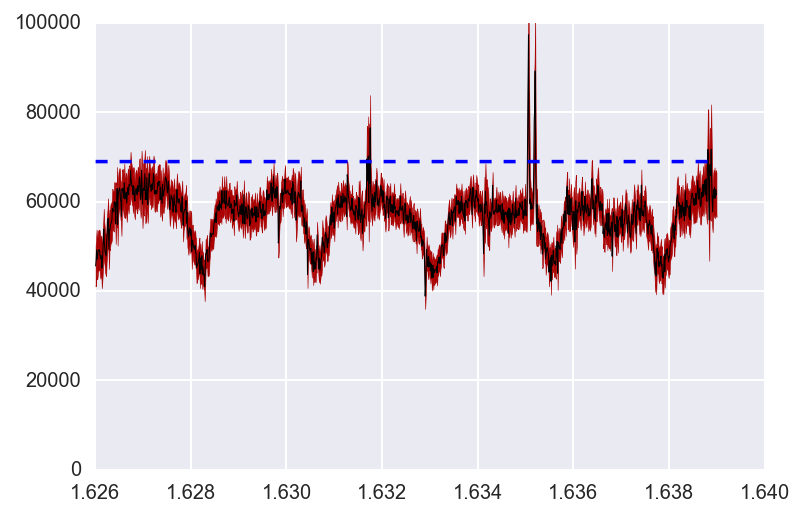

In [27]:
plt.plot(wlgrid, Flux, 'k-', lw=0.5)
plt.fill_between(wlgrid, Flux-3.0*Flux_err, Flux+3.0*Flux_err, color='#AA0000')
plt.plot(wlgrid, wlgrid*0.0+69000, 'b--')
plt.ylim(0,100000)

In [28]:
bi = (Flux > 69000) | (Flux_err == 0)
Flux_err_alt = Flux_err[~bi]
Flux = Flux[~bi]
wlgrid = wlgrid[~bi]

(0, 100000)

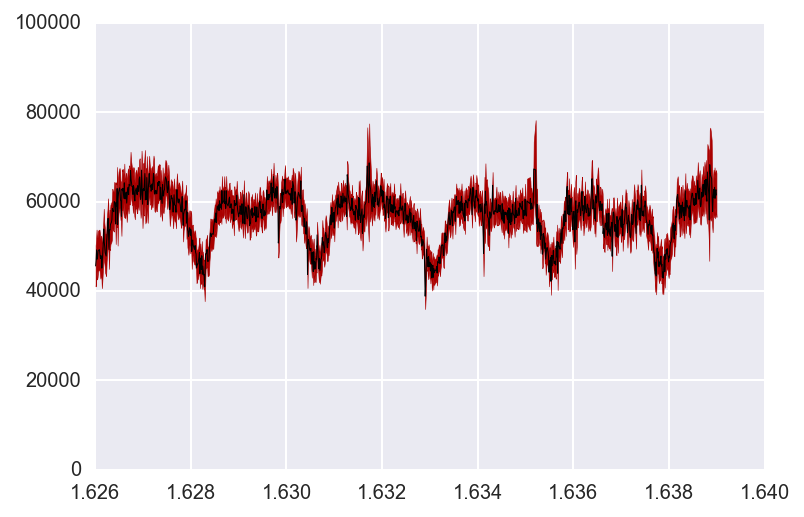

In [29]:
plt.plot(wlgrid, Flux, 'k-', lw=0.5)
plt.fill_between(wlgrid, Flux-3.0*Flux_err_alt, Flux+3.0*Flux_err_alt, color='#AA0000')
plt.ylim(0,100000)

Much better.

In [30]:
out_name = '../data/IGRINS/reduced/2M0136+0933_m110.hdf5'
fls_out = Flux
sig_out = Flux_err_alt
wls_out = wlgrid*10000.0
msk_out = np.ones(len(wls_out), dtype=int)
f_new = h5py.File(out_name, 'w')
f_new.create_dataset('fls', data=fls_out)
f_new.create_dataset('wls', data=wls_out)
f_new.create_dataset('sigmas', data=sig_out)
f_new.create_dataset('masks', data=msk_out)
print("{:.0f}  -  {:.0f}   {}".format(wls_out[0], wls_out[-1], out_name))
f_new.close()

16260  -  16390   ../data/IGRINS/reduced/2M0136+0933_m110.hdf5


### x1, x2 = 1.612, 1.625 # m111

In [43]:
x1, x2 = 1.612, 1.625 # m111
gi = (dat.wl> x1) & (dat.wl < x2)
wlgrid = dat.wl[gi].values
Flux = dat.fl[gi].values
Flux_err = np.abs(dat.sigma[gi].values)

(40000, 100000)

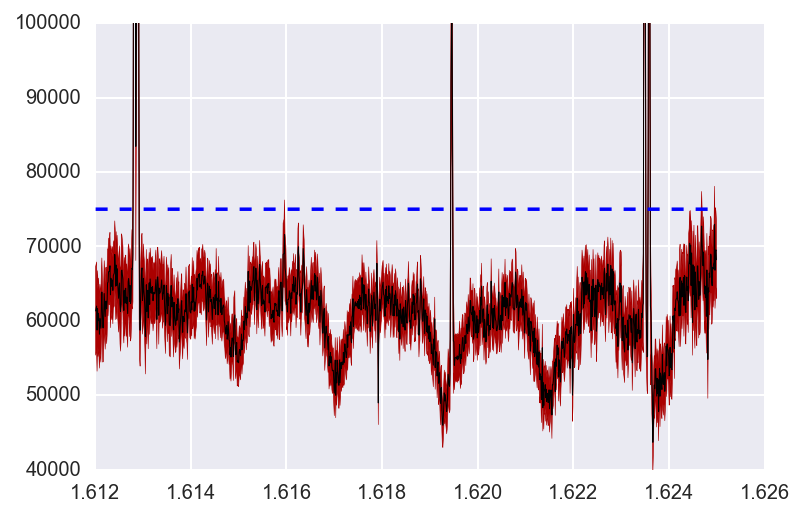

In [44]:
plt.plot(wlgrid, Flux, 'k-', lw=0.5)
plt.fill_between(wlgrid, Flux-3.0*Flux_err, Flux+3.0*Flux_err, color='#AA0000')
plt.plot(wlgrid, wlgrid*0.0+75000, 'b--')
plt.ylim(40000,100000)

In [45]:
bi = (Flux > 75000) | (Flux_err == 0)
Flux_err_alt = Flux_err[~bi]
Flux = Flux[~bi]
wlgrid = wlgrid[~bi]

(0, 100000)

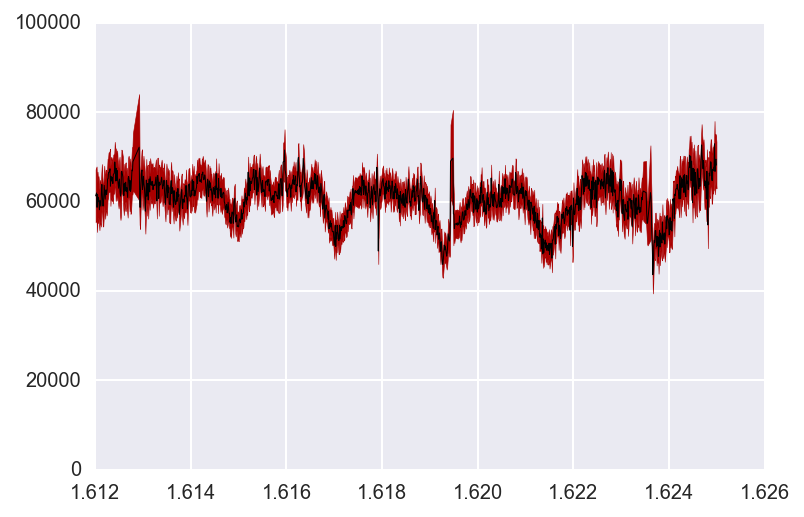

In [47]:
plt.plot(wlgrid, Flux, 'k-', lw=0.5)
plt.fill_between(wlgrid, Flux-3.0*Flux_err_alt, Flux+3.0*Flux_err_alt, color='#AA0000')
plt.ylim(0,100000)

Much better.

In [48]:
out_name = '../data/IGRINS/reduced/2M0136+0933_m111.hdf5'
fls_out = Flux
sig_out = Flux_err_alt
wls_out = wlgrid*10000.0
msk_out = np.ones(len(wls_out), dtype=int)
f_new = h5py.File(out_name, 'w')
f_new.create_dataset('fls', data=fls_out)
f_new.create_dataset('wls', data=wls_out)
f_new.create_dataset('sigmas', data=sig_out)
f_new.create_dataset('masks', data=msk_out)
print("{:.0f}  -  {:.0f}   {}".format(wls_out[0], wls_out[-1], out_name))
f_new.close()

16120  -  16250   ../data/IGRINS/reduced/2M0136+0933_m111.hdf5


### x1, x2 = 1.598, 1.611 # m112

In [49]:
x1, x2 = 1.598, 1.611 # m112
gi = (dat.wl> x1) & (dat.wl < x2)
wlgrid = dat.wl[gi].values
Flux = dat.fl[gi].values
Flux_err = np.abs(dat.sigma[gi].values)

Let's manually clean the bad pixels.

(38000, 100000)

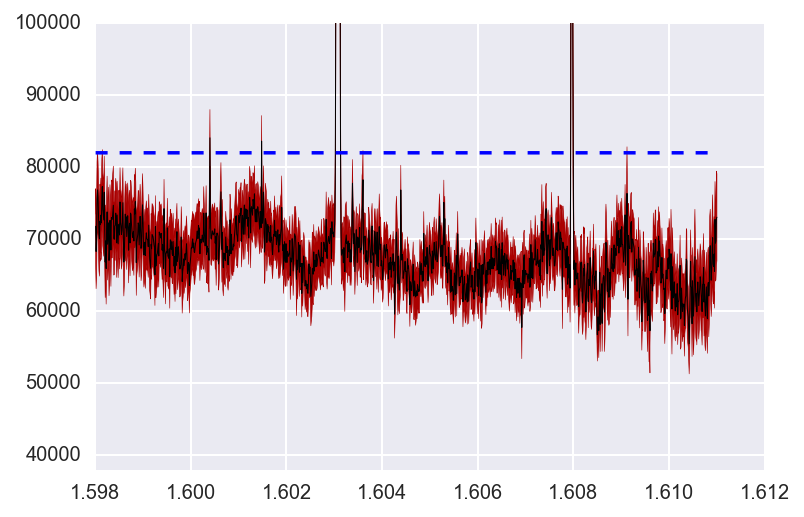

In [54]:
plt.plot(wlgrid, Flux, 'k-', lw=0.5)
plt.fill_between(wlgrid, Flux-3.0*Flux_err, Flux+3.0*Flux_err, color='#AA0000')
plt.plot(wlgrid, wlgrid*0.0+82000, 'b--')
plt.ylim(38000,100000)

In [55]:
bi = (Flux > 82000) | (Flux_err == 0)
Flux_err_alt = Flux_err[~bi]
Flux = Flux[~bi]
wlgrid = wlgrid[~bi]

(0, 100000)

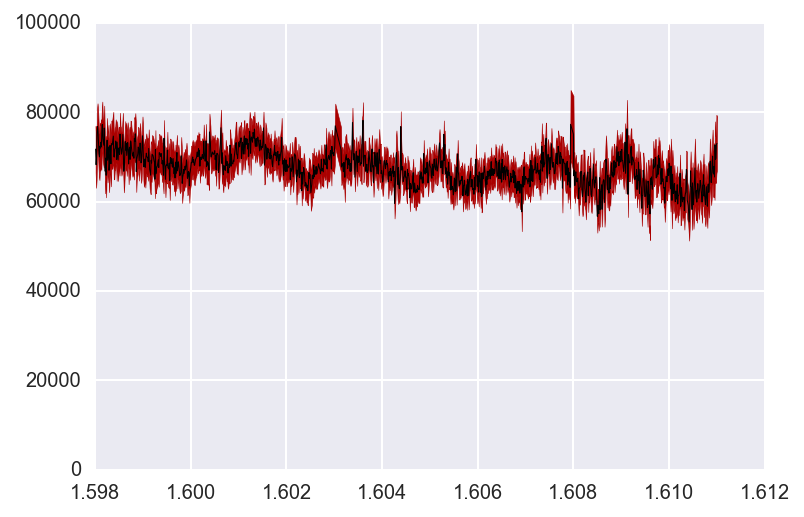

In [56]:
plt.plot(wlgrid, Flux, 'k-', lw=0.5)
plt.fill_between(wlgrid, Flux-3.0*Flux_err_alt, Flux+3.0*Flux_err_alt, color='#AA0000')
plt.ylim(0,100000)

Much better.

In [57]:
out_name = '../data/IGRINS/reduced/2M0136+0933_m112.hdf5'
fls_out = Flux
sig_out = Flux_err_alt
wls_out = wlgrid*10000.0
msk_out = np.ones(len(wls_out), dtype=int)
f_new = h5py.File(out_name, 'w')
f_new.create_dataset('fls', data=fls_out)
f_new.create_dataset('wls', data=wls_out)
f_new.create_dataset('sigmas', data=sig_out)
f_new.create_dataset('masks', data=msk_out)
print("{:.0f}  -  {:.0f}   {}".format(wls_out[0], wls_out[-1], out_name))
f_new.close()

15980  -  16110   ../data/IGRINS/reduced/2M0136+0933_m112.hdf5


### x1, x2 = 1.572, 1.583 # m114

In [58]:
x1, x2 = 1.572, 1.583 # m114
gi = (dat.wl> x1) & (dat.wl < x2)
wlgrid = dat.wl[gi].values
Flux = dat.fl[gi].values
Flux_err = np.abs(dat.sigma[gi].values)

Let's manually clean the bad pixels.

(20000, 100000)

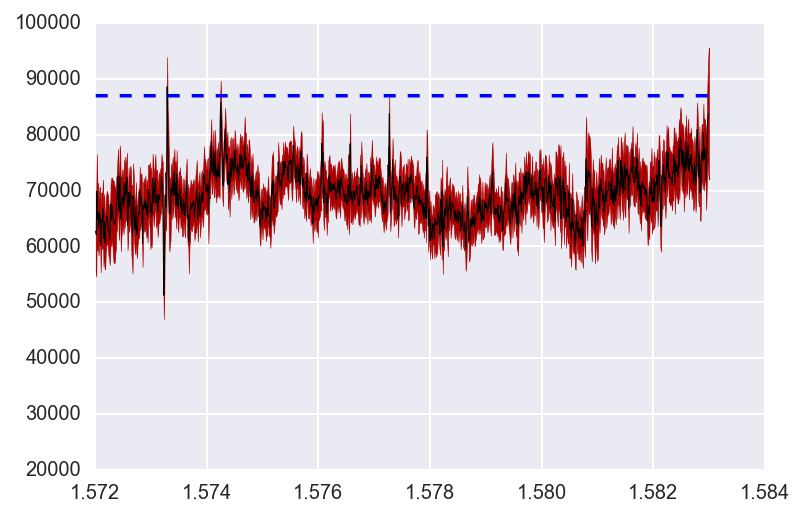

In [61]:
plt.plot(wlgrid, Flux, 'k-', lw=0.5)
plt.fill_between(wlgrid, Flux-3.0*Flux_err, Flux+3.0*Flux_err, color='#AA0000')
plt.plot(wlgrid, wlgrid*0.0+87000, 'b--')
plt.ylim(20000,100000)

In [62]:
bi = (Flux > 87000) | (Flux_err == 0)
Flux_err_alt = Flux_err[~bi]
Flux = Flux[~bi]
wlgrid = wlgrid[~bi]

(0, 100000)

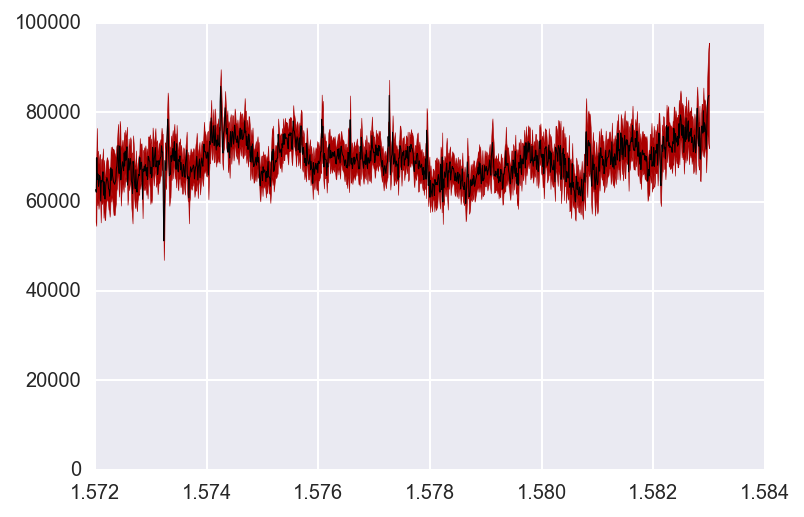

In [63]:
plt.plot(wlgrid, Flux, 'k-', lw=0.5)
plt.fill_between(wlgrid, Flux-3.0*Flux_err_alt, Flux+3.0*Flux_err_alt, color='#AA0000')
plt.ylim(0,100000)

Better.

In [64]:
out_name = '../data/IGRINS/reduced/2M0136+0933_m114.hdf5'
fls_out = Flux
sig_out = Flux_err_alt
wls_out = wlgrid*10000.0
msk_out = np.ones(len(wls_out), dtype=int)
f_new = h5py.File(out_name, 'w')
f_new.create_dataset('fls', data=fls_out)
f_new.create_dataset('wls', data=wls_out)
f_new.create_dataset('sigmas', data=sig_out)
f_new.create_dataset('masks', data=msk_out)
print("{:.0f}  -  {:.0f}   {}".format(wls_out[0], wls_out[-1], out_name))
f_new.close()

15720  -  15830   ../data/IGRINS/reduced/2M0136+0933_m114.hdf5


### Three left:

In [79]:
x1, x2 = 1.533, 1.544 # m117
x1, x2 = 1.5445, 1.557 # m116
x1, x2 = 1.559, 1.570 # m115

### x1, x2 = 1.559, 1.570 # m115

In [66]:
x1, x2 = 1.559, 1.570 # m115
gi = (dat.wl> x1) & (dat.wl < x2)
wlgrid = dat.wl[gi].values
Flux = dat.fl[gi].values
Flux_err = np.abs(dat.sigma[gi].values)

Let's manually clean the bad pixels.

(20000, 100000)

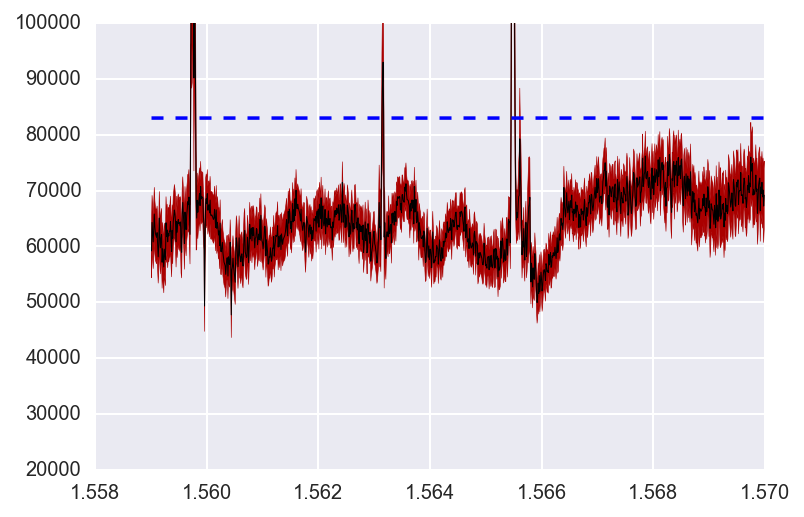

In [68]:
plt.plot(wlgrid, Flux, 'k-', lw=0.5)
plt.fill_between(wlgrid, Flux-3.0*Flux_err, Flux+3.0*Flux_err, color='#AA0000')
plt.plot(wlgrid, wlgrid*0.0+83000, 'b--')
plt.ylim(20000,100000)

In [69]:
bi = (Flux > 83000) | (Flux_err == 0)
Flux_err_alt = Flux_err[~bi]
Flux = Flux[~bi]
wlgrid = wlgrid[~bi]

(0, 100000)

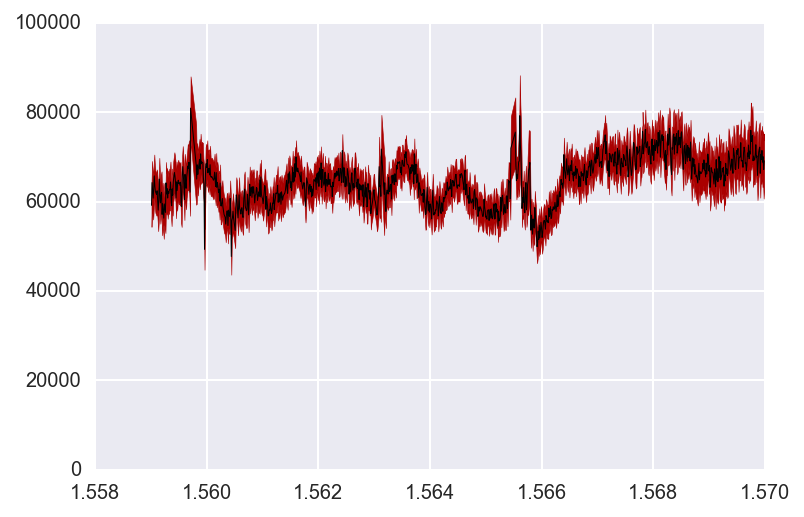

In [70]:
plt.plot(wlgrid, Flux, 'k-', lw=0.5)
plt.fill_between(wlgrid, Flux-3.0*Flux_err_alt, Flux+3.0*Flux_err_alt, color='#AA0000')
plt.ylim(0,100000)

Better.

In [71]:
out_name = '../data/IGRINS/reduced/2M0136+0933_m115.hdf5'
fls_out = Flux
sig_out = Flux_err_alt
wls_out = wlgrid*10000.0
msk_out = np.ones(len(wls_out), dtype=int)
f_new = h5py.File(out_name, 'w')
f_new.create_dataset('fls', data=fls_out)
f_new.create_dataset('wls', data=wls_out)
f_new.create_dataset('sigmas', data=sig_out)
f_new.create_dataset('masks', data=msk_out)
print("{:.0f}  -  {:.0f}   {}".format(wls_out[0], wls_out[-1], out_name))
f_new.close()

15590  -  15700   ../data/IGRINS/reduced/2M0136+0933_m115.hdf5


### x1, x2 = 1.5445, 1.557 # m116

In [73]:
x1, x2 = 1.5445, 1.557 # m116
gi = (dat.wl> x1) & (dat.wl < x2)
wlgrid = dat.wl[gi].values
Flux = dat.fl[gi].values
Flux_err = np.abs(dat.sigma[gi].values)

Let's manually clean the bad pixels.

(20000, 100000)

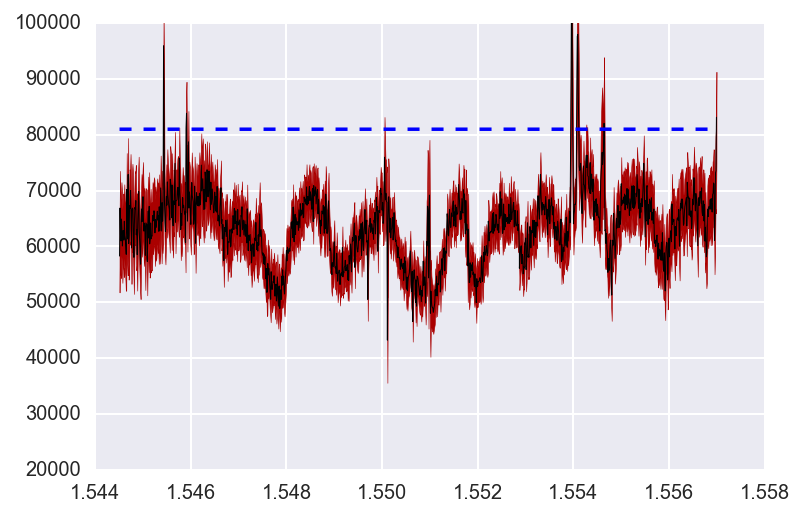

In [75]:
plt.plot(wlgrid, Flux, 'k-', lw=0.5)
plt.fill_between(wlgrid, Flux-3.0*Flux_err, Flux+3.0*Flux_err, color='#AA0000')
plt.plot(wlgrid, wlgrid*0.0+81000, 'b--')
plt.ylim(20000,100000)

In [76]:
bi = (Flux > 81000) | (Flux_err == 0)
Flux_err_alt = Flux_err[~bi]
Flux = Flux[~bi]
wlgrid = wlgrid[~bi]

(0, 100000)

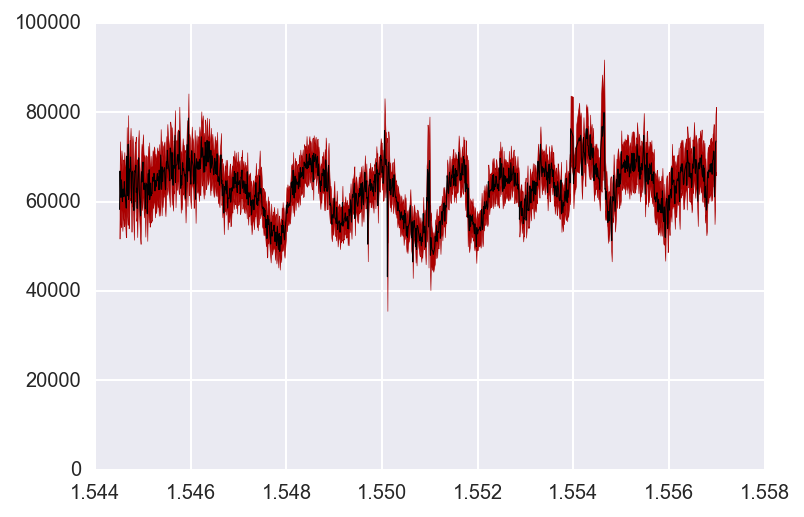

In [77]:
plt.plot(wlgrid, Flux, 'k-', lw=0.5)
plt.fill_between(wlgrid, Flux-3.0*Flux_err_alt, Flux+3.0*Flux_err_alt, color='#AA0000')
plt.ylim(0,100000)

Better.

In [78]:
out_name = '../data/IGRINS/reduced/2M0136+0933_m116.hdf5'
fls_out = Flux
sig_out = Flux_err_alt
wls_out = wlgrid*10000.0
msk_out = np.ones(len(wls_out), dtype=int)
f_new = h5py.File(out_name, 'w')
f_new.create_dataset('fls', data=fls_out)
f_new.create_dataset('wls', data=wls_out)
f_new.create_dataset('sigmas', data=sig_out)
f_new.create_dataset('masks', data=msk_out)
print("{:.0f}  -  {:.0f}   {}".format(wls_out[0], wls_out[-1], out_name))
f_new.close()

15445  -  15570   ../data/IGRINS/reduced/2M0136+0933_m116.hdf5


### x1, x2 = 1.533, 1.544 # m117

In [80]:
x1, x2 = 1.533, 1.544 # m117
gi = (dat.wl> x1) & (dat.wl < x2)
wlgrid = dat.wl[gi].values
Flux = dat.fl[gi].values
Flux_err = np.abs(dat.sigma[gi].values)

Let's manually clean the bad pixels.

(20000, 100000)

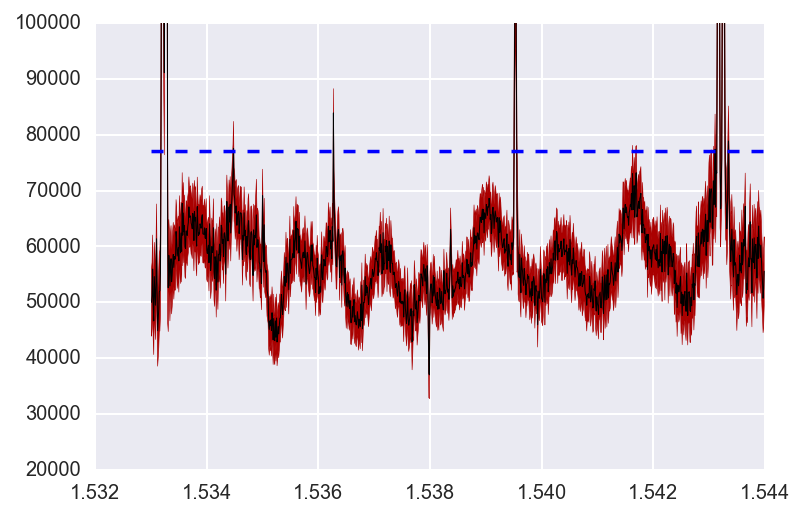

In [84]:
plt.plot(wlgrid, Flux, 'k-', lw=0.5)
plt.fill_between(wlgrid, Flux-3.0*Flux_err, Flux+3.0*Flux_err, color='#AA0000')
plt.plot(wlgrid, wlgrid*0.0+77000, 'b--')
plt.ylim(20000,100000)

In [85]:
bi = (Flux > 77000) | (Flux_err == 0)
Flux_err_alt = Flux_err[~bi]
Flux = Flux[~bi]
wlgrid = wlgrid[~bi]

(0, 100000)

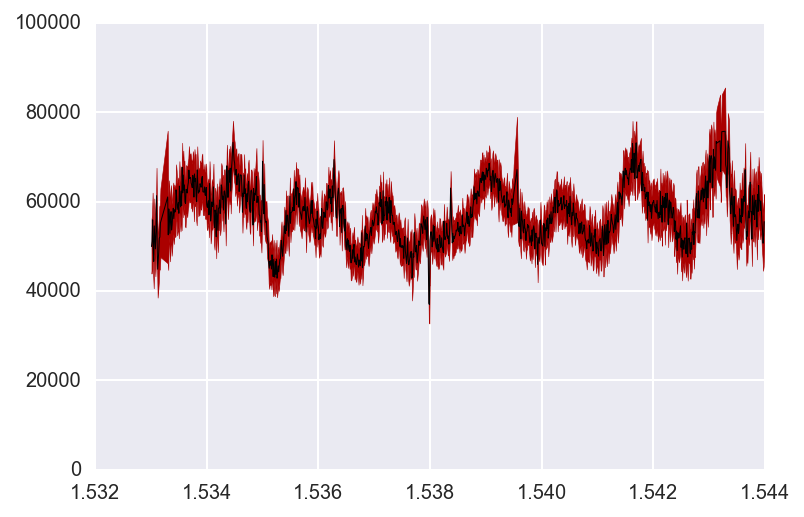

In [86]:
plt.plot(wlgrid, Flux, 'k-', lw=0.5)
plt.fill_between(wlgrid, Flux-3.0*Flux_err_alt, Flux+3.0*Flux_err_alt, color='#AA0000')
plt.ylim(0,100000)

Better.

In [87]:
out_name = '../data/IGRINS/reduced/2M0136+0933_m117.hdf5'
fls_out = Flux
sig_out = Flux_err_alt
wls_out = wlgrid*10000.0
msk_out = np.ones(len(wls_out), dtype=int)
f_new = h5py.File(out_name, 'w')
f_new.create_dataset('fls', data=fls_out)
f_new.create_dataset('wls', data=wls_out)
f_new.create_dataset('sigmas', data=sig_out)
f_new.create_dataset('masks', data=msk_out)
print("{:.0f}  -  {:.0f}   {}".format(wls_out[0], wls_out[-1], out_name))
f_new.close()

15330  -  15440   ../data/IGRINS/reduced/2M0136+0933_m117.hdf5


## THE END.